In [1]:
# 2022--5-11
# try to see the output of single attetnion layer

In [4]:
import torch
import torch.nn as nn

In [5]:
class SelfAttentionBlock(nn.Module):
    def __init__(self, embed_size, heads):
        super(SelfAttentionBlock, self).__init__()

        self.embed_size = embed_size
        self.heads = heads
        self.heads_dim = embed_size // heads
        assert (self.heads_dim * heads == embed_size), "embed_size should be divisible by heads."

        self.get_values = nn.Linear(self.heads_dim, self.heads_dim, bias = False)
        self.get_keys = nn.Linear(self.heads_dim, self.heads_dim, bias = False)
        self.get_queries = nn.Linear(self.heads_dim, self.heads_dim, bias = False)
        self.fc_out = nn.Linear(heads * self.heads_dim, embed_size)

    def forward(self, values_x, keys_x, queries_x, mask):
        # split embedding into self.heads pieces
        N = queries_x.shape[0]
        values_len, keys_len, queries_len = values_x.shape[1], keys_x.shape[1], queries_x.shape[1]
        values_x = values_x.reshape(N, values_len, self.heads, self.heads_dim)
        keys_x = keys_x.reshape(N, keys_len, self.heads, self.heads_dim)
        queries_x = queries_x.reshape(N, queries_len, self.heads, self.heads_dim)

        # getting v, k, q from x
        values = self.get_values(values_x)
        keys = self.get_keys(keys_x)
        queries = self.get_queries(queries_x)

        '''
        Using torch.einsum to compute tensors multiplication
            params
            ------
            queries (N, queries_len, heads, heads_dim) --> (nqhd)
            keys (N, keys_len, heads, heads_dim) --> (nkhd)
            
            returns
            ------
            energy (N, heads, queries_len, keys_len) --> (nhqk)
        '''
        energy = torch.einsum("nqhd, nkhd -> nhqk", [queries, keys])

        if mask is not None:
            energy = energy.masked_fill_(mask == 0, float("-1e20")) # mask == None: shut that off, so that it does not impact any other.
            
        # attention(V, K, Q) = softmax(Q  K^T / embed_size ** (1/ 2)) * V

        attention = torch.softmax(energy / (self.embed_size ** (1/2)), dim = 3)
        attention_out = torch.einsum("nhqk, nvhd -> nqhd", [attention, values]).reshape(N, queries_len, self.heads * self.heads_dim)
        out = self.fc_out(attention_out)  
        return out

In [6]:
source_vocab_size = 10
source_padding_idx = 0

target_vocab_size = 10
target_padding_idx = 0

max_length = 100 
dropout = 0.
embed_size = 256
heads = 8
head_dim = embed_size // heads

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
selfattention_model = SelfAttentionBlock(embed_size, heads).to(device)

In [8]:
selfattention_model.eval()

SelfAttentionBlock(
  (get_values): Linear(in_features=32, out_features=32, bias=False)
  (get_keys): Linear(in_features=32, out_features=32, bias=False)
  (get_queries): Linear(in_features=32, out_features=32, bias=False)
  (fc_out): Linear(in_features=256, out_features=256, bias=True)
)

In [9]:
import PIL.Image as Image

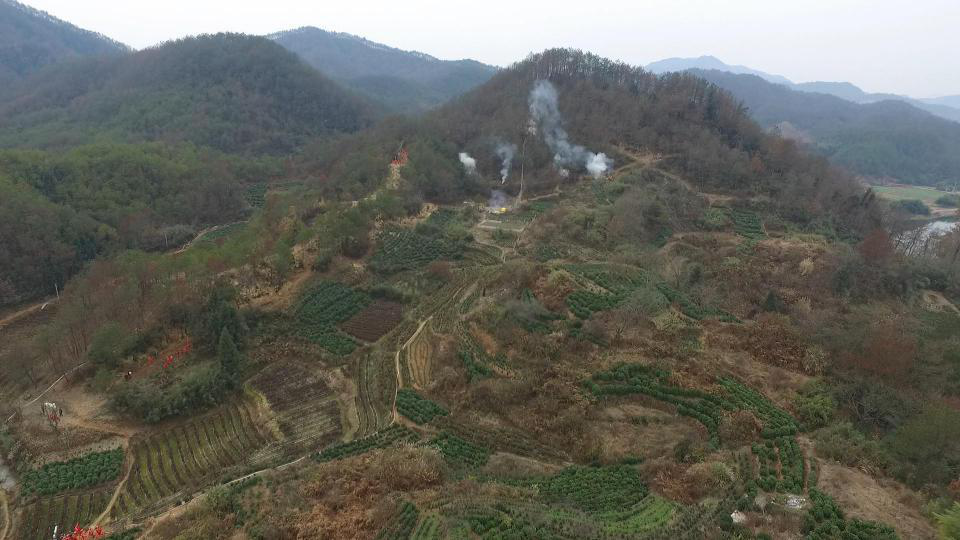

In [13]:
img = Image.open('/home/qiao/dev/giao/datasets/S_kaggle_wildfire/000001.jpg')
img

In [15]:
from embeddingblock import EmbeddingBlock